# Set Up

## Retrieving Articles

In [5]:
"""Retrieving Articles

Strcuture:
    1. Imports, Variables, Functions
    2. Fetching Recent Papers
    3. Fetching Citation Counts
"""

# 1. Imports, Variables, Functions
# imports
import requests
from datetime import datetime, timedelta
import xml.etree.ElementTree as ET
import logging

logging.basicConfig(level=logging.INFO)

from tqdm.contrib.concurrent import (
    process_map,
)  # Import process_map for multiprocessing

# variables
journals = [
    "Bioinformatics",
    "BMC Bioinformatics",
    "Nucleic Acids Research",
    "Genome Research",
    "Genome Biology",
    "PLOS Computational Biology",
    "Journal of Computational Biology",
    "Journal of Biomedical Informatics",
    "Journal of Cheminformatics",
    "Molecular Informatics",
    "Journal of Chemical Information and Modeling",
    "Nature Machine Intelligence",
    "IEEE/ACM Transactions on Computational Biology and Bioinformatics",
    "Computational and Structural Biotechnology Journal",
    "Briefings in Bioinformatics",
    "Systems Biology and Applications",
    "BioSystems",
    "Algorithms for Molecular Biology",
    "BMC Genomics",
    "BMC Systems Biology",
    "BMC Evolutionary Biology",
    "BioData Mining",
    "PLOS Genetics",
    "Journal of Proteome Research",
    "Proteins: Structure, Function, and Bioinformatics",
    "Molecular Systems Biology",
    "Cell Systems",
    "GigaScience",
    "Nature Biomedical Engineering",  # While broader, it includes significant bioinformatics research.
    "Patterns (Cell Press)",  # Focuses on data science that impacts science and society, including bioinformatics.
]


journal_queries = ['"' + journal + '"[Journal]' for journal in journals]

# query = 'chemoinformatics OR "AI biomedicine"'
query = " OR ".join(journal_queries)


# functions
def fetch_citation_count(pmid):
    """
    Fetch citation count for a given PMID.
    """
    elink_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi"
    params = {
        "dbfrom": "pubmed",
        "db": "pubmed",
        "id": pmid,
        "linkname": "pubmed_pubmed_citedin",  # Link to citing articles
        "retmode": "xml",
    }

    response = requests.get(elink_url, params=params)
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        citation_count = len(root.findall(".//LinkSetDb/Link"))
        return citation_count
    return 0  # Return 0 if unable to fetch citation count


def fetch_citations_for_papers(papers):
    """
    Fetch citation counts for a list of papers in parallel.
    """
    pmids = [paper["pmid"] for paper in papers]
    citation_counts = process_map(fetch_citation_count, pmids, max_workers=10)
    for paper, citation_count in zip(papers, citation_counts):
        paper["citations"] = citation_count
    return papers


def fetch_recent_papers(query, days_ago=90, n_articles=10000):
    """
    Fetch recent papers from PubMed based on a query and include citation counts.
    """
    # Calculate date range
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days_ago)
    start_date_str = start_date.strftime("%Y/%m/%d")
    end_date_str = end_date.strftime("%Y/%m/%d")

    # PubMed API endpoint
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": f'({query}) AND ("{start_date_str}"[Date - Publication] : "{end_date_str}"[Date - Publication])',
        "retmax": n_articles,
        "usehistory": "y",
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        webenv = root.find(".//WebEnv").text
        query_key = root.find(".//QueryKey").text

        # Fetch actual paper details using efetch
        fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
        fetch_params = {
            "db": "pubmed",
            "query_key": query_key,
            "WebEnv": webenv,
            "retmode": "xml",
            "rettype": "abstract",
            "retmax": n_articles,
        }
        fetch_response = requests.get(fetch_url, params=fetch_params)
        if fetch_response.status_code == 200:
            fetch_root = ET.fromstring(fetch_response.content)
            papers = []
            for article in fetch_root.findall(".//PubmedArticle"):
                title = article.find(".//ArticleTitle").text
                pmid = article.find(".//PMID").text
                link = f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/"

                # Extract keywords
                keyword_list = article.find(".//KeywordList")

                keywords = (
                    [keyword.text for keyword in keyword_list.findall(".//Keyword")]
                    if keyword_list is not None
                    else []
                )

                # New code to fetch abstracts
                abstract_text = article.find(".//Abstract/AbstractText")
                abstract = (
                    abstract_text.text
                    if abstract_text is not None
                    else "Abstract not available"
                )

                papers.append(
                    {
                        "title": title,
                        "pmid": pmid,
                        "link": link,
                        "keywords": keywords,
                        "abstract": abstract,
                    }
                )
            return papers
    return "Failed to fetch papers or no papers found."


# 2. Fetching Recent Papers
papers = fetch_recent_papers(query)
logging.info(f"Nº of papers: {len(papers)}")

# 3. Fetching Citation Counts
papers = fetch_citations_for_papers(papers)
logging.info(
    f"Nº of papers w/ citations in less than 3 months: {len([p for p in papers if p['citations'] > 0])}"
)

INFO:root:Nº of papers: 2449
/tmp/ipykernel_272977/1879717520.py:89: TqdmWarning: Iterable length 2449 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  citation_counts = process_map(fetch_citation_count, pmids, max_workers=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got fork

In [6]:
papers = [p for p in papers if p["citations"] > 0]

In [7]:
# 4. Store Data
"""Store Data so that there is a memory for which papers have been fetched.

"""

import pandas as pd

df_papers = pd.DataFrame(papers)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [8]:
df_papers

,title,pmid,link,keywords,abstract,citations
0,Computational reproducibility of Jupyter noteb...,38206590,https://pubmed.ncbi.nlm.nih.gov/38206590/,"[GitHub, Jupyter notebooks, PubMed Central, Py...",Jupyter notebooks facilitate the bundling of e...,1
1,Counterfactual formulation of patient-specific...,38191012,https://pubmed.ncbi.nlm.nih.gov/38191012/,"[Causal discovery, Causal inference, Computati...",Root causes of disease intuitively correspond ...,1
2,Whole-genome long-read sequencing downsampling...,38190646,https://pubmed.ncbi.nlm.nih.gov/38190646/,[],Advances in long-read sequencing (LRS) technol...,1
3,CEMIG: prediction of the cis-regulatory motif ...,38189539,https://pubmed.ncbi.nlm.nih.gov/38189539/,"[algorithms, chromatin accessibility, cluster ...",Sequence motif discovery algorithms enhance th...,1
4,Structural coverage of the human interactome.,38180828,https://pubmed.ncbi.nlm.nih.gov/38180828/,"[AlphaFold2, PDB, homology modeling databases,...",Complex biological processes in cells are embe...,1
5,Hotspot propensity across mutational processes.,38177930,https://pubmed.ncbi.nlm.nih.gov/38177930/,"[Mutation Rate Variability, Mutation Rate Vari...",The sparsity of mutations observed across tumo...,1
6,Auditing the inference processes of medical-im...,38155295,https://pubmed.ncbi.nlm.nih.gov/38155295/,[],The inferences of most machine-learning models...,1
7,PyRates-A code-generation tool for modeling dy...,38150479,https://pubmed.ncbi.nlm.nih.gov/38150479/,[],The mathematical study of real-world dynamical...,1
8,An agent-based modeling approach for lung fibr...,38127835,https://pubmed.ncbi.nlm.nih.gov/38127835/,[],The severity of the COVID-19 pandemic has crea...,1
9,PANoptosis signaling enables broad immune resp...,38125299,https://pubmed.ncbi.nlm.nih.gov/38125299/,"[Disulfiram, Immune, Network pharmacology, PAN...",Accumulating evidence suggests that regulated ...,1


## Local usage LLMs

In [63]:
"""Local usage LLMs

Structure:
    1. Imports, Variables, Functions
    2. Load the Model
    3. Answer Prompt Request
"""

# 1. Imports, Variables, Functions
# imports
from transformers import pipeline
import os, sys
from tqdm import tqdm

# variables
prompt = "Summarize the following abstract from a scientific article: %s"
model_path = os.path.join("..", "data", "llama-2-7b-chat.Q4_K_M.gguf")


# functions


# 2. Load the Model
summarizer = pipeline("summarization", model="../bart-large-cnn")

In [68]:
summarizer(
    "Sam Shleifer writes the best docstring examples in the whole world.",
    min_length=3,
    max_length=15,
)

[{'summary_text': 'Sam Shleifer writes the best docstring examples in the'}]

In [24]:
# 3. Answer Prompt Request
abstract_summaries = list()
for index, row in tqdm(df_papers.iterrows()):
    if row["abstract"] is not None:
        abstract_summary = summarizer(
            prompt % row["abstract"], max_length=60, min_length=30, do_sample=False
        )[0]["summary_text"]
    else:
        abstract_summary = None
    abstract_summaries.append(abstract_summary)

df_papers["abstract_summary"] = abstract_summaries

17it [00:45,  2.64s/it]Your max_length is set to 60, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
34it [01:32,  2.71s/it]


## Posting to Twitter

In [50]:
"""Posting to Twitter

Structure:
    1. Imports, Variables, Functions
    2. Authenticate to Twitter
    3. Posting to Twitter

"""

# 1. Imports, Variables, Functions
# imports
import tweepy
import logging
from dotenv import load_dotenv
import os

logging.basicConfig(level=logging.INFO)

# variables
api_key = os.getenv("API_KEY")
api_key_secret = os.getenv("API_KEY_SECRET")
bearer_token = os.getenv("BEARER_TOKEN")
access_token = os.getenv("ACCESS_TOKEN")
access_token_secret = os.getenv("ACCESS_TOKEN_SECRET")

# functions


# 2. Authenticate to Twitter
client = tweepy.Client(
    consumer_key=api_key,
    consumer_secret=api_key_secret,
    access_token=access_token,
    access_token_secret=access_token_secret,
)
auth = tweepy.OAuth1UserHandler(
    api_key, api_key_secret, access_token, access_token_secret
)
api = tweepy.API(auth)

# 3. Posting to Twitter

client.create_tweet(text="Hellos, world!")

Response(data={'edit_history_tweet_ids': ['1759507685110645060'], 'id': '1759507685110645060', 'text': 'Hellos, world!'}, includes={}, errors=[], meta={})

## Testing Area

In [60]:
def fetch_recent_papers(query, days_ago=1000, n_articles=10):
    """
    Fetch recent papers from PubMed based on a query and include citation counts.
    """
    # Calculate date range
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days_ago)
    start_date_str = start_date.strftime("%Y/%m/%d")
    end_date_str = end_date.strftime("%Y/%m/%d")

    # PubMed API endpoint
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": f'({query}) AND ("{start_date_str}"[Date - Publication] : "{end_date_str}"[Date - Publication])',
        "retmax": n_articles,
        "usehistory": "y",
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        webenv = root.find(".//WebEnv").text
        query_key = root.find(".//QueryKey").text

        # Fetch actual paper details using efetch
        fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
        fetch_params = {
            "db": "pubmed",
            "query_key": query_key,
            "WebEnv": webenv,
            "retmode": "xml",
            "rettype": "abstract",
            "retmax": n_articles,
        }
        fetch_response = requests.get(fetch_url, params=fetch_params)
        if fetch_response.status_code == 200:
            fetch_root = ET.fromstring(fetch_response.content)
            papers = []
            for article in fetch_root.findall(".//PubmedArticle"):
                title = article.find(".//ArticleTitle").text
                pmid = article.find(".//PMID").text
                link = f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/"

                # Attempt to extract the DOI
                article_doi = article.find(".//ArticleId[@IdType='doi']")
                doi = article_doi.text if article_doi is not None else None

                # Construct the link to the full article using DOI
                doi_link = f"https://doi.org/{doi}" if doi else "Link not available"

                # Extract keywords
                keyword_list = article.find(".//KeywordList")

                keywords = (
                    [keyword.text for keyword in keyword_list.findall(".//Keyword")]
                    if keyword_list is not None
                    else []
                )

                # New code to fetch abstracts
                abstract_text = article.find(".//Abstract/AbstractText")
                abstract = (
                    abstract_text.text
                    if abstract_text is not None
                    else "Abstract not available"
                )

                papers.append(
                    {
                        "title": title,
                        "pmid": pmid,
                        "link": link,
                        "doi_link": doi_link,
                        "keywords": keywords,
                        "abstract": abstract,
                    }
                )
            return papers
    return "Failed to fetch papers or no papers found."

In [61]:
a = fetch_recent_papers(query="paper")

In [56]:
import json, os
import pandas as pd

path_csv = os.path.join("..", "results", "papers_to_tweet.csv")


def load_tweeted_pmids():
    path_tweeted_pmids = os.path.join("..", "results", "tweeted_pmids.json")

    try:
        with open(path_tweeted_pmids, "r") as f:
            return set(json.load(f))  # Load and convert list back to set
    except FileNotFoundError:
        return set()  # Return an empty set if the file doesn't exist


# Load the latest DataFrame and tweeted_pmids at the beginning of each call
df_papers = pd.read_csv(path_csv)
tweeted_pmids = load_tweeted_pmids()

# check if the papers haven't been tweeted already
available_papers = df_papers[~df_papers["pmid"].isin(tweeted_pmids)]
if available_papers.empty:
    logging.info("All papers have been tweeted.")

paper = available_papers.sample(1).iloc[0]  # Randomly select an untweeted paper

n_title = 0
n_title_truncated = 0
n_title_abstract = 0
n_title_abstract_truncated = 0


for ind, paper in available_papers.iterrows():
    min_abstract_length = 60
    # check if the paper has an abstract
    if isinstance(paper["abstract_summary"], str):

        # check there is room for abstract ! ! !
        tweet_content = f"{paper['title']}\n{paper['doi_link']}"

        # check if there is room for abstract
        if len(tweet_content) < 280 - min_abstract_length:
            # There is room for an abstract ! ! !
            room_available = 280 - len(tweet_content) - 2  # +2 \n\n
            # check if there is room for entire abstract summary
            if len(paper["abstract_summary"]) < room_available:
                n_title_abstract += 1
                print("entire abstract summary")
                tweet_content = f"{paper['title']}\n\n{paper['abstract_summary']}\n{paper['doi_link']}"
            # check if there is room for a truncated abstract summary
            else:
                print("Truncated abstract summary")
                n_title_abstract_truncated += 1
                tweet_content = f"{paper['title']}\n\n{paper['abstract_summary'][:room_available-5]}...\n{paper['doi_link']}"

        else:
            # check if there is room for a title ! ! !

            if len(tweet_content) < 280:
                n_title += 1
                print("Title only")
                # redundant
                tweet_content = f"{paper['title']}\n{paper['doi_link']}"
            else:
                n_title_truncated += 1
                print("Truncated title only")
                space_left = 280 - len(tweet_content)
                tweet_content = (
                    f"{paper['title'][:space_left-4]}...\n{paper['doi_link']}"
                )

        assert (
            len(tweet_content) <= 280
        ), f"Tweet content too long: {len(tweet_content)} characters"

    # If the paper doesn't have an abstract, tweet the title and DOI link
    else:
        # check there is room for abstract ! ! !
        tweet_content = f"{paper['title']}\n{paper['doi_link']}"
        # check if there is room for a title ! ! !
        if len(tweet_content) < 280:
            print(" title only")
            n_title += 1

            # redundant
            tweet_content = f"{paper['title']}\n{paper['doi_link']}"
        else:
            print("Truncated title only")
            n_title_truncated += 1
            space_left = 280 - len(tweet_content)
            tweet_content = f"{paper['title'][:space_left-4]}...\n{paper['doi_link']}"

        assert (
            len(tweet_content) <= 280
        ), f"Tweet content too long: {len(tweet_content)} characters"

    print(tweet_content)

entire abstract summary
Predictive coding networks for temporal prediction.

Predictive coding is a well-established computational framework for describing perceptual processes in the brain.
https://doi.org/10.1371/journal.pcbi.1011183
entire abstract summary
NeuronBridge: an intuitive web application for neuronal morphology search across large data sets.

 Neuroscience research in Drosophila is benefiting from large-scale connectomics efforts using electron microscopy.
https://doi.org/10.1186/s12859-024-05732-7
entire abstract summary
Mathematical models of Plasmodium vivax transmission: A scoping review.

Plasmodium vivax is one of the most geographically widespread malaria parasites in the world.
https://doi.org/10.1371/journal.pcbi.1011931
entire abstract summary
Prediction of protein-ligand binding affinity via deep learning models.

Accurately predicting the binding affinity between proteins and ligands is crucial in drug screening and optimization.
https://doi.org/10.1093/bib/bb

In [47]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 37.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.1 MB/s eta 0:00:00a 0:00:01


<BarContainer object of 4 artists>

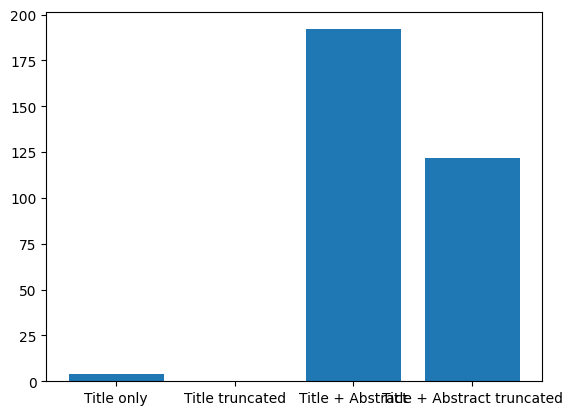

In [57]:
from matplotlib import pyplot as plt

plt.bar(
    ["Title only", "Title truncated", "Title + Abstract", "Title + Abstract truncated"],
    [n_title, n_title_truncated, n_title_abstract, n_title_abstract_truncated],
)

# Testing